Saving enriched_skincare_products.csv to enriched_skincare_products.csv

📥 Reading file: enriched_skincare_products.csv

🔹 Shape before dropna and fillna:
(200, 13)

🔹 Shape after cleaning:
(200, 13)


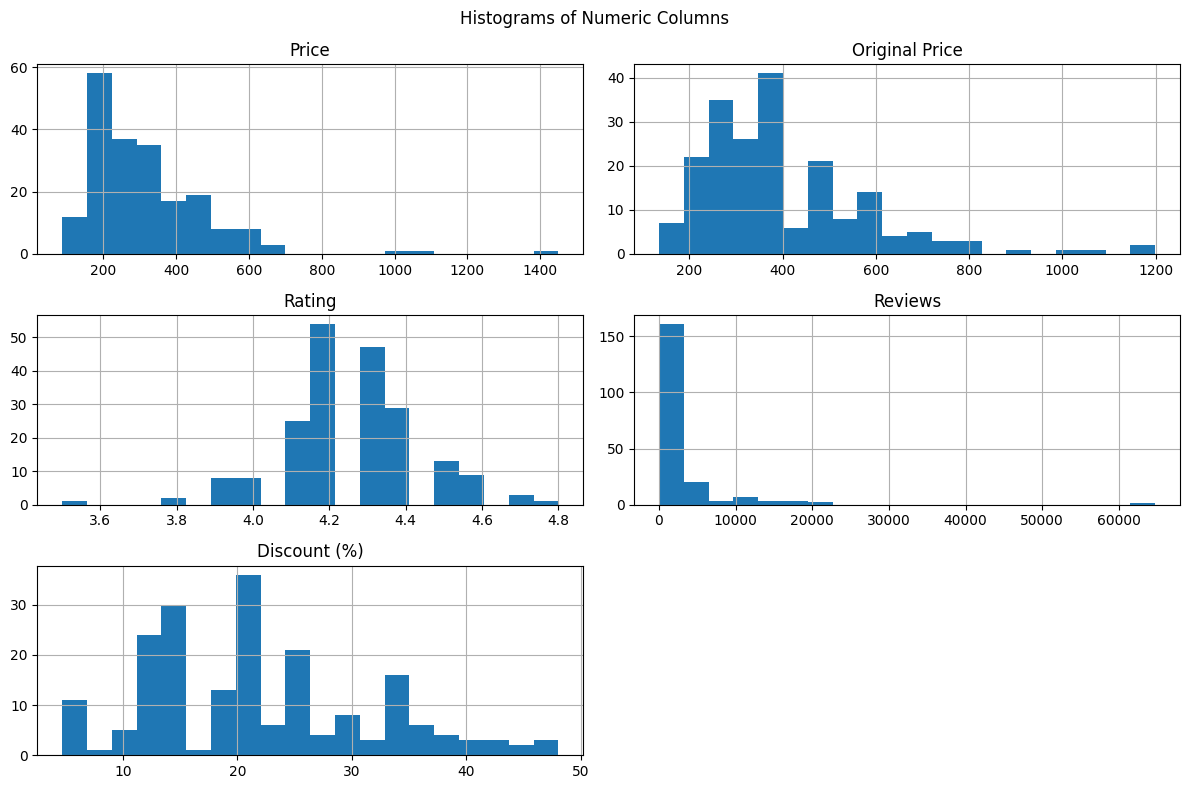

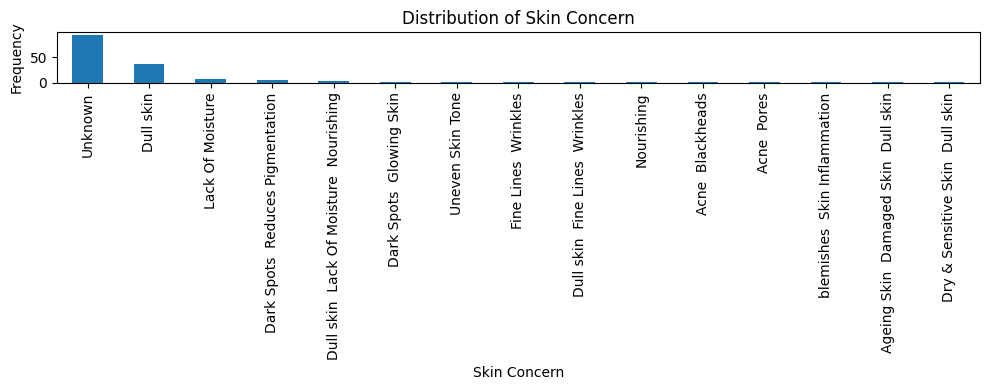

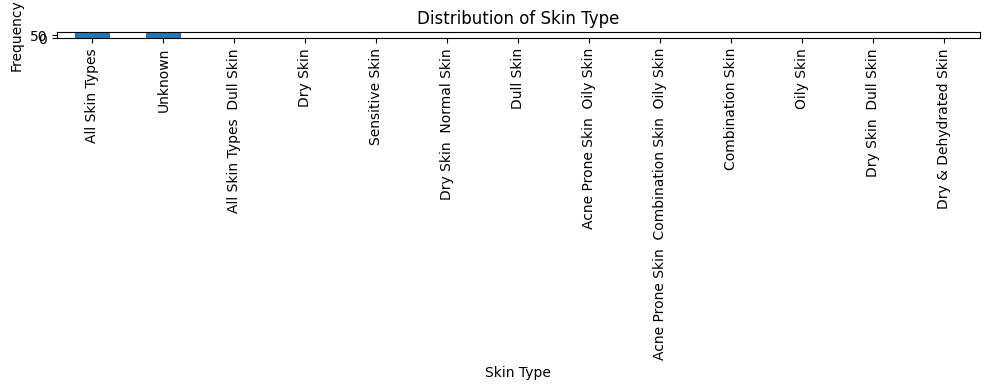

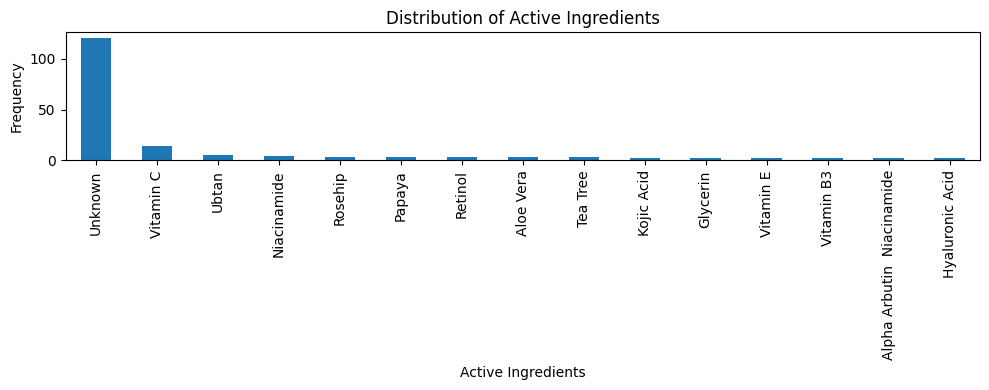

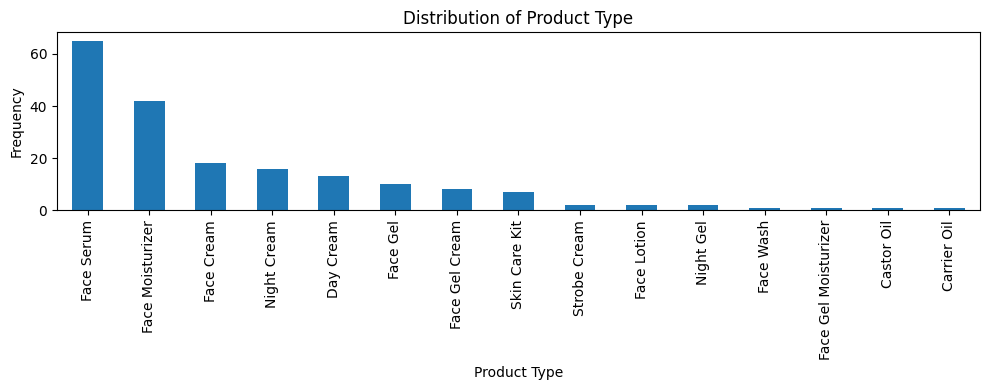

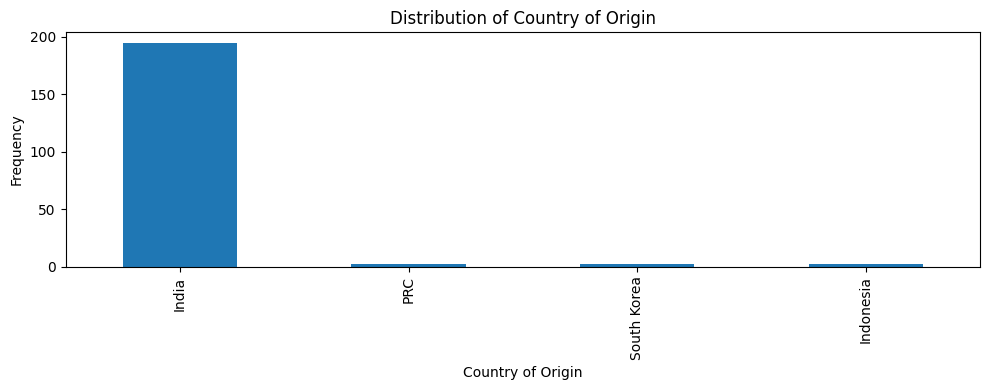

<ipython-input-1-3c9d351c8e9d>:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


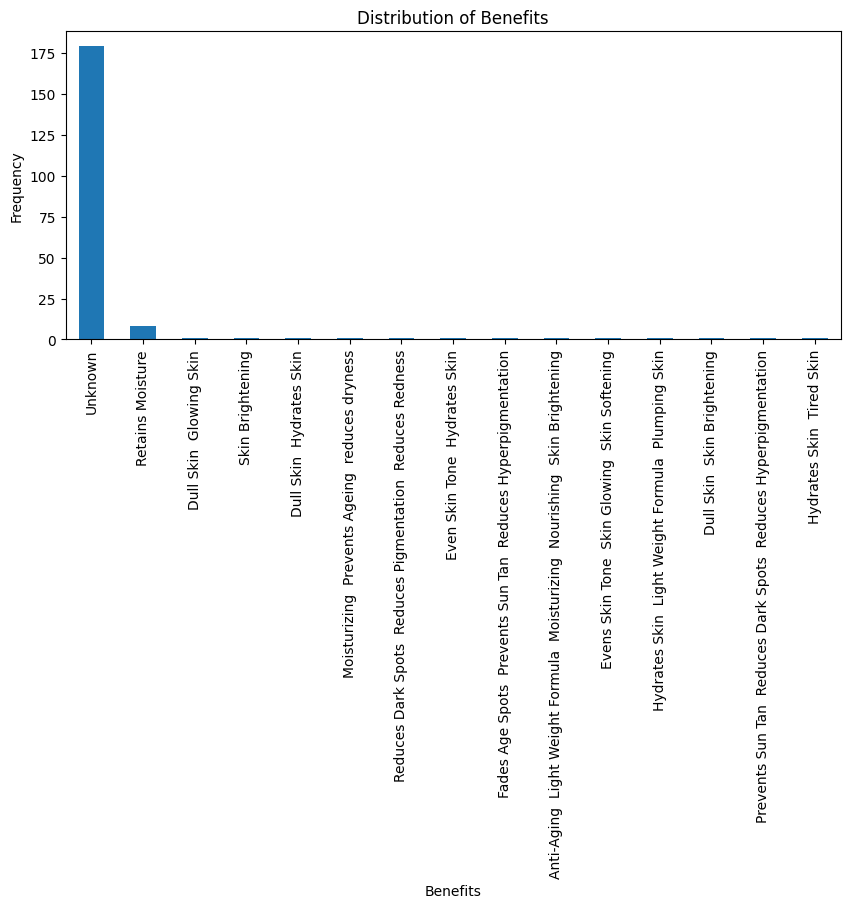

<ipython-input-1-3c9d351c8e9d>:87: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


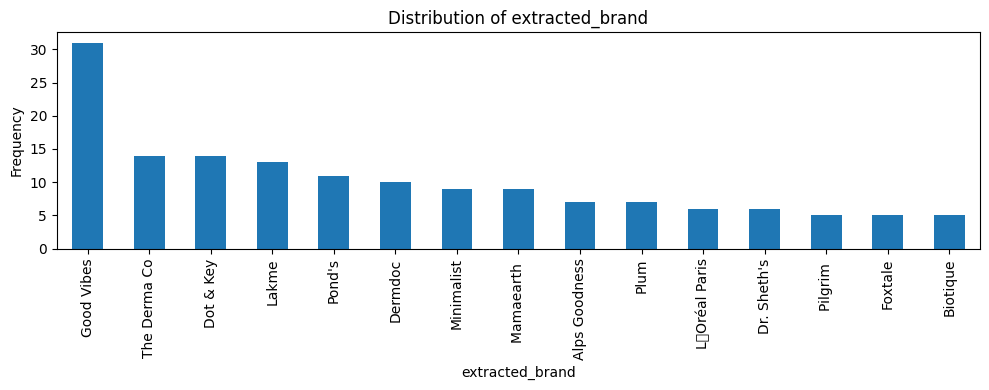

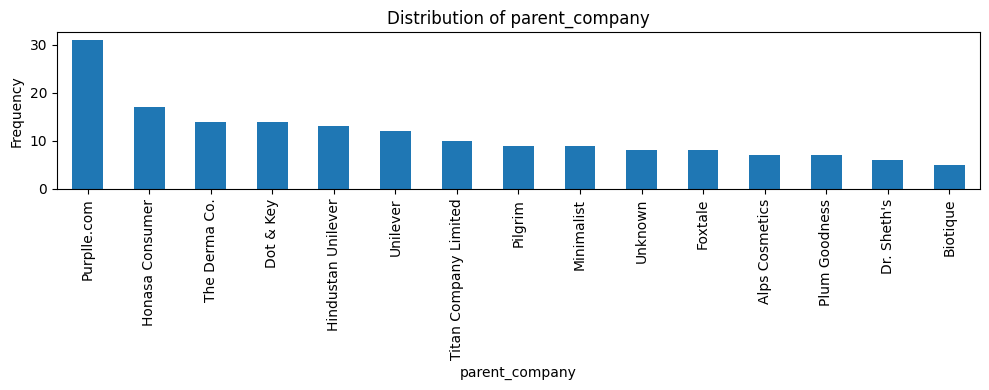


🔹 Correlation Matrix:
                   Price  Original Price    Rating   Reviews  Discount (%)
Price           1.000000        0.822528 -0.083156 -0.217382     -0.226629
Original Price  0.822528        1.000000 -0.052070 -0.224142      0.023664
Rating         -0.083156       -0.052070  1.000000 -0.043200      0.186424
Reviews        -0.217382       -0.224142 -0.043200  1.000000      0.160818
Discount (%)   -0.226629        0.023664  0.186424  0.160818      1.000000


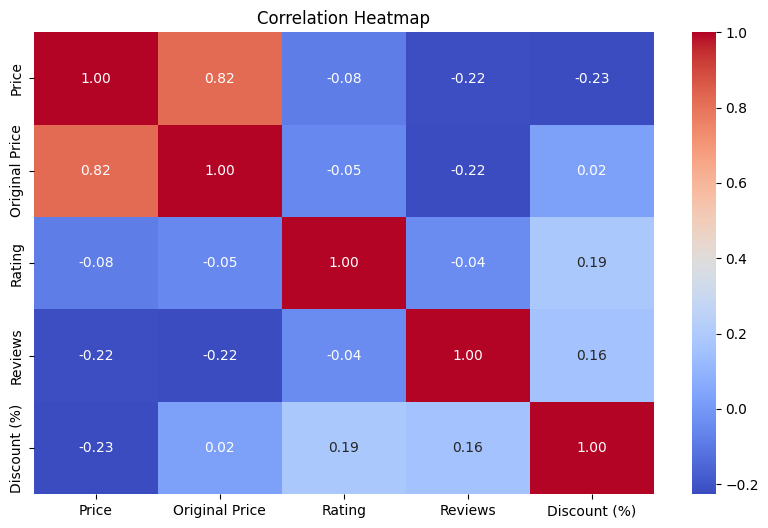


✅ Done. Cleaned DataFrame ready.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import files

# 📤 Upload the CSV file
uploaded = files.upload()
csv_file_path = list(uploaded.keys())[0]

def eda_report(csv_file_path, na_values=None):
    if na_values is None:
        na_values = ["None", "none", "NA", "N/A", "n/a", "null", "NULL", "-", "", " "]

    print(f"\n📥 Reading file: {csv_file_path}")
    df = pd.read_csv(csv_file_path, na_values=na_values)

    # 🧹 Fix weird characters
    df.replace({'â¹': '₹', 'â\x82¹': '₹'}, regex=True, inplace=True)

    # 🔻 Drop unneeded columns if present
    drop_cols = [
        "Name", "Primary Concerns", "Primary Benefits", "Speciality",
        "Product Format", "Hair Concern", "Hair Type"
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # 🧼 Clean Price & Original Price
    def clean_currency(col):
        return (
            df[col]
            .astype(str)
            .str.replace(r'[^\d.]', '', regex=True)
            .replace('', pd.NA)
            .dropna()
            .astype(float)
        )

    df['Price'] = df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    df['Original Price'] = df['Original Price'].astype(str).str.replace(r'[^\d.]', '', regex=True)
    df['Original Price'] = pd.to_numeric(df['Original Price'], errors='coerce')

    # 🔢 Rating and Reviews
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

    # ➕ Discount %
    df["Discount (%)"] = ((df["Original Price"] - df["Price"]) / df["Original Price"]) * 100
    df["Discount (%)"] = df["Discount (%)"].round(2)

    # 🔻 Clean categorical values
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.replace(",", " ", regex=False)

    print("\n🔹 Shape before dropna and fillna:")
    print(df.shape)

    # Fill categorical NA with "Unknown", numeric with median
    categorical_cols = df.select_dtypes(include=['object', 'string']).columns
    numeric_cols = df.select_dtypes(include='number').columns

    df[categorical_cols] = df[categorical_cols].fillna("Unknown")
    for col in numeric_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

    # 🧹 Remove duplicates
    df = df.drop_duplicates()

    print("\n🔹 Shape after cleaning:")
    print(df.shape)

    # 📊 Histograms
    df[numeric_cols].hist(figsize=(12, 8), bins=20)
    plt.suptitle('Histograms of Numeric Columns')
    plt.tight_layout()
    plt.show()

    # 📊 Top categorical distributions
    for col in categorical_cols:
        df[col].value_counts().head(15).plot(kind='bar', figsize=(10, 4))
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # 🔗 Correlation heatmap
    print("\n🔹 Correlation Matrix:")
    corr = df[numeric_cols].corr()
    print(corr)

    if not corr.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

    # 🔢 Encode low-cardinality categoricals
    df_encoded = df.copy()
    for col in categorical_cols:
        if df[col].nunique() < 20:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df[col])
        else:
            df_encoded = df_encoded.drop(columns=[col])

    print("\n✅ Done. Cleaned DataFrame ready.")
    return df_encoded

# 🧪 Run EDA + clean
df_cleaned = eda_report(csv_file_path)

# 💾 Save & download
output_file = "cleaned_skin1.csv"
df_cleaned.to_csv(output_file, index=False)
files.download(output_file)

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from google.colab import files

# Upload CSV manually in Colab
uploaded = files.upload()

# Read the uploaded file
for filename in uploaded.keys():
    print(f"\n📂 File uploaded: {filename}")
    df = pd.read_csv(filename)

# Display basic info
print("\n🔹 First few rows of the dataset:")
print(df.head())

# Assume the last column is the target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

column_name = df.columns[-1]
print(f"\n🎯 Target column detected: {column_name}")

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Store model results
results = []

# Evaluate models
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()

    # Avoid division by zero in MAPE
    non_zero_indices = y_test != 0
    y_test_non_zero = y_test[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_test_non_zero - y_pred_non_zero) / y_test_non_zero)) * 100 if len(y_test_non_zero) > 0 else np.nan

    results.append({
        "Model": name,
        "R² Score": round(r2_score(y_test, y_pred), 4),
        "MAE": round(mean_absolute_error(y_test, y_pred), 4),
        "MAPE (%)": round(mape, 2),
        "Train Time (s)": round(end - start, 3)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values(by="MAE")

# Display results
print("\n📊 Model Evaluation Summary:")
print(results_df.to_string(index=False))

Saving cleaned_skin1.csv to cleaned_skin1 (1).csv

📂 File uploaded: cleaned_skin1 (1).csv

🔹 First few rows of the dataset:
   Price  Original Price  Rating  Reviews  Skin Type  Country of Origin  \
0    298           350.0     4.1  20768.0          2                  0   
1    242           285.0     4.3  16905.0         12                  0   
2    247           290.0     4.2  16482.0         12                  0   
3    170           284.0     4.5  16855.0          3                  0   
4    199           269.0     4.0  15327.0         12                  0   

   Benefits  Discount (%)  
0        14         14.86  
1        14         15.09  
2        14         14.83  
3         1         40.14  
4        14         26.02  

🎯 Target column detected: Discount (%)

📊 Model Evaluation Summary:
                   Model  R² Score    MAE  MAPE (%)  Train Time (s)
       XGBoost Regressor    0.6673 3.3282     21.72           0.499
           Random Forest    0.5008 4.5731     35.18 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files

# 📂 Upload CSV file manually
uploaded = files.upload()

# Load the uploaded file (assuming only one file is uploaded)
for filename in uploaded.keys():
    print(f"\n✅ Loaded file: {filename}")
    df = pd.read_csv(filename)

# 🎯 Define features and target
X = df.drop('Discount (%)', axis=1)
y = df['Discount (%)']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# 🧪 Grid Search CV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2
)
grid_search.fit(X_train, y_train)

# ✅ Best hyperparameters
best_params = grid_search.best_params_
print(f"\n🏆 Best Hyperparameters: {best_params}")

# Final model with best parameters
best_xgb_model = grid_search.best_estimator_

# Predict
y_pred = best_xgb_model.predict(X_test)

# 📊 Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print("\n🔍 Model Evaluation after Hyperparameter Tuning:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

Saving cleaned_skin1.csv to cleaned_skin1 (2).csv

✅ Loaded file: cleaned_skin1 (2).csv
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learnin

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from google.colab import files

# Upload the file
uploaded = files.upload()

# Automatically read the uploaded file and load it into a DataFrame
for filename in uploaded.keys():
    print(f"✅ Loaded: {filename}")
    df = pd.read_csv(filename)

# Display the first few rows to check the data
print("First few rows of the dataset:")
print(df.head())

# Assume 'Price' is the target variable and others are features
X = df.drop(columns=["Price"])  # Drop the target column from the feature set
y = df["Price"]  # Target column

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters from GridSearchCV
print("\n🏆 Best Hyperparameters:")
print(grid_search.best_params_)

# Evaluate the model using the best parameters
best_model = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_model.predict(X_test)

# Model Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Displaying the evaluation metrics
print("\n🔍 Model Evaluation after Hyperparameter Tuning:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Predictions for the first 5 rows in the test set
print("\n🔮 Predictions for first 5 rows:")
print(y_pred[:5])

Saving cleaned_skin1.csv to cleaned_skin1 (3).csv
✅ Loaded: cleaned_skin1 (3).csv
First few rows of the dataset:
   Price  Original Price  Rating  Reviews  Skin Type  Country of Origin  \
0    298           350.0     4.1  20768.0          2                  0   
1    242           285.0     4.3  16905.0         12                  0   
2    247           290.0     4.2  16482.0         12                  0   
3    170           284.0     4.5  16855.0          3                  0   
4    199           269.0     4.0  15327.0         12                  0   

   Benefits  Discount (%)  
0        14         14.86  
1        14         15.09  
2        14         14.83  
3         1         40.14  
4        14         26.02  
Fitting 3 folds for each of 972 candidates, totalling 2916 fits

🏆 Best Hyperparameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

🔍 Model Evaluation after Hyperparameter Tuning:
R² S